Let $s$ be a sequence of i.i.d. unbiased coin flips (heads are 1, tails are 0), represented as series $I(t)$ of input pulses with pulse width 1 when $s_m = 1$. Given a 1-D linear system with timescale $\tau$ we want to figure out response distribution $P(r)$ given response resolution $1/\Delta r$, where 

$$r = \int_0^\infty \frac{1}{\tau}\exp(-t/\tau) I(-t) dt$$

and where $t=0$ aligns with the pulse boundary (i.e. so $t=0$ is never in the middle of a pulse).

We want to calculate the probability that $r$ lands in the nth bin of size $\Delta r$ where the number of bins is $N = 1/\Delta r$. 

Note $0 \leq r \leq 1$, $n \in \{0, 1, ..., N-1\}$.

We have $$P(r \textrm{ in nth bin}) = P(n\Delta r \leq r < (n+1)\Delta r) = 1 - P(r < n\Delta r) - P(r \geq (n+1)\Delta r)$$

If the mth symbol, whose pulse spans time $m$ and $m+1$, is 1, it contributes

$$r_m = \int_m^{m+1} \frac{1}{\tau} \exp(-t/\tau) dt = -[\exp(-(m+1)/\tau) - \exp(-m/\tau)] = \exp(-m/\tau)[1 - \exp(-1/\tau)]$$

and 0 if the symbol is 0.

Thus, $$r = \sum_{m=0}^\infty s_mr_m = [1 - \exp(-1/\tau)]\sum_{m=0}^\infty s_m\exp(-m/\tau) = \gamma_\tau \sum_{m=0}^\infty s_m\exp(-m/\tau)$$

So $$P(r < n\Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) < n\frac{\Delta r}{\gamma_\tau}\right)$$ 

and 

$$P(r \geq (n+1) \Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) \geq (n+1)\frac{\Delta r}{\gamma_\tau} \right)$$ 

We thus need to figure out the cumulative distribution and survival functions of an exponentially weighted sum of i.i.d. unbiased Bernoulli variables. Note the bounds $0 \leq \sum_{m=0}^\infty s_m\exp(-m/\tau) \leq 1/\gamma_\tau$.

Since all sequences $s$ have equal probability we can approach this by counting what fraction of sequences end up below/above a specific value. Although there are infinite sequences $s$ they are countable, and we can sort them 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


def s2r(s, tau=None, a=None):
    """s should be (N x T), returns r (N x N_A), tau or a should be 1-D arrays"""
    assert (tau is not None) or (a is not None)
    
    n, t = s.shape
    
    if tau is not None:
        a = np.exp(-1/tau)
    
    assert a.ndim == 1
    n_a = len(a)
    
    a = np.tile(a[None, :], (t, 1))
    a_m = (1-a)*(a**np.tile(np.arange(t)[:, None], (1, n_a)))
    
    return s @ a_m

# Demonstration of response distribution vs timescale for unbiased i.i.d. binary inputs

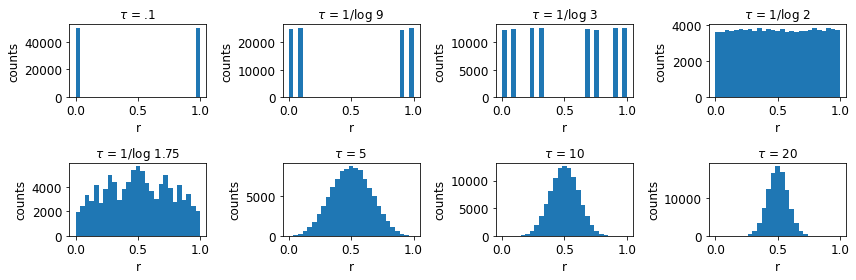

In [2]:
tau = np.array([.1, 1/np.log(9), 1/np.log(3), 1/np.log(2), 1/np.log(1.75), 5, 10, 20])
label = ['.1', '1/log 9', '1/log 3', '1/log 2', '1/log 1.75', '5', '10', '20']
t = int(round(10*tau.max()))
n = 100000

s = np.random.binomial(1, .5, (n, t))

r = s2r(s, tau)

fig, axs = plt.subplots(2, 4, figsize=(12, 4), tight_layout=True)
for label_, r_, ax in zip(label, r.T, axs.flat):
    ax.hist(r_, bins=np.linspace(0, 1, 28))
    ax.set_title(fr'$\tau$ = {label_}')
    ax.set_xlabel('r')
    ax.set_ylabel('counts')
    
set_font_size(axs, 12)

In [3]:
from scipy import stats

a = np.linspace(.01, .99, 99)
tau = -1/np.log(a)
t = int(round(10*tau.max()))
n = 500000

s = np.random.binomial(1, .5, (n, t))
r = s2r(s, a=a)

nbin = [3, 9, 27, 81, 243, 729]

h = np.nan * np.zeros((len(nbin), len(a)))
cts_plt = []

for cnbin, nbin_ in enumerate(nbin):
    ct_plt = np.nan * np.zeros((nbin_, len(a)))
    for ctau, r_ in enumerate(r.T):
        
        bins = np.linspace(0, 1, nbin_+1)
        bins[0] -= .00001
        bins[-1] += .00001
        
        ct_r = np.histogram(r_, bins=bins)[0]
        h[cnbin, ctau] = stats.entropy(ct_r/np.sum(ct_r), base=2)
        ct_plt[:, ctau] = ct_r/ct_r.max()
        
    cts_plt.append(ct_plt)

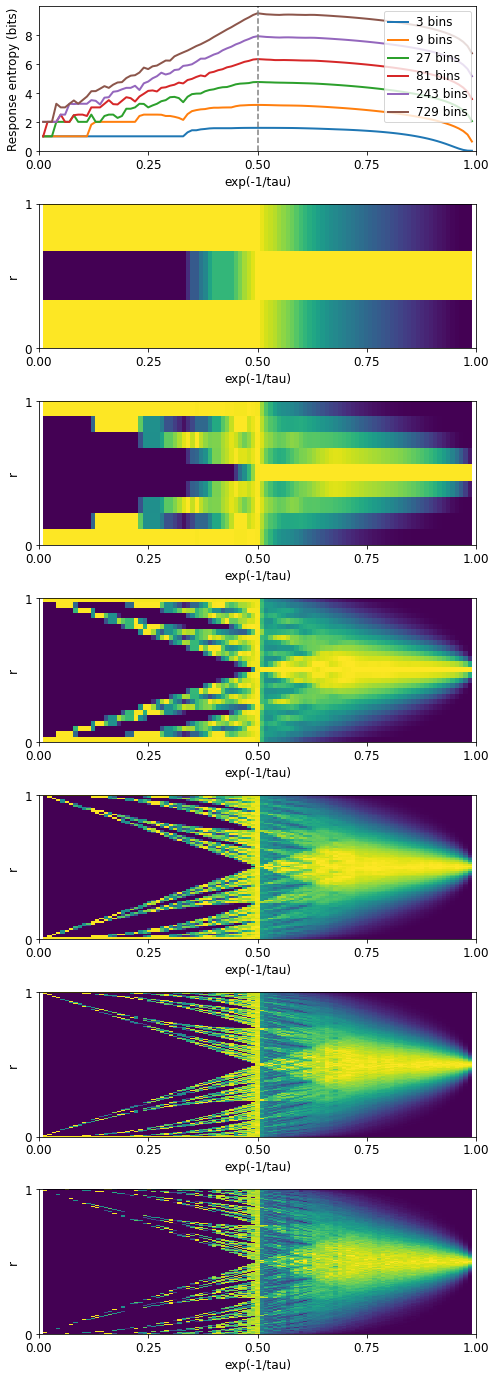

In [4]:
fig, axs = plt.subplots(1+len(nbin), 1, figsize=(7, 2.75*(1+len(nbin))), tight_layout=True)
axs[0].plot(a, h.T, lw=2)
axs[0].axvline(.5, color='gray', ls='--')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(bottom=0)
axs[0].set_xticks(np.linspace(0, 1, 5))
axs[0].set_xlabel('exp(-1/tau)')
axs[0].set_ylabel('Response entropy (bits)')
axs[0].legend([f'{nbin_} bins' for nbin_ in nbin], loc='upper right')

for nbin_, ct_plt, ax in zip(nbin, cts_plt, axs[1:]):
    ax.matshow(ct_plt, origin='lower', interpolation='nearest', extent=[0.01, .99, 0, 1])
    ax.set_aspect('auto')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.xaxis.tick_bottom()
    ax.set_xlabel('exp(-1/tau)')
    ax.set_ylabel('r')
set_font_size(axs, 12)

As before, we consider the random process with samples given by

$$r(\tau) = [1 - e^{-1/\tau}]\sum_{m=0}^\infty e^{-m/\tau} s_m$$

where $\{s_m\}$ are binary values sampled from some random process of their own. Or defining $a = \exp(-1/\tau), \tau = -1/\log a$ we can write

$$r(-1/\log a) = [1-a]\sum_{m=0}^\infty a^m s_m$$

where $a = 0 \rightarrow \tau = 0$, $a = 1 \rightarrow \tau = \infty$.

Given some $P(\{s_m\})$ we can now sample $r(-1/\log a)$ over the domain $a \in [0, 1)$.

# Demonstrate binary-to-analog encoding at optimal timescale

In [5]:
def s2i(s):
    i = np.tile(s[:, None], (1, 2)).flatten()
    t = np.array([np.arange(-len(s), 0), np.arange(-len(s), 0)+1]).T.flatten()
    if i[0] == 1:
        i = np.concatenate([[0], i])
        t = np.concatenate([[-len(s)], t])
    if i[-1] == 1:
        i = np.concatenate([i, [0]])
        t = np.concatenate([t, [0]])
        
    return t, i

t_i, i = s2i(s)

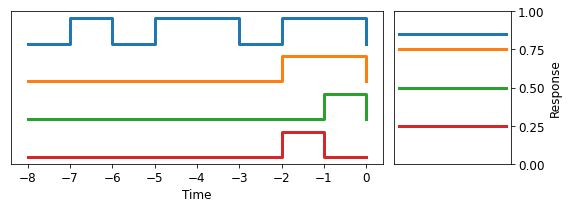

In [6]:
import matplotlib.gridspec as gridspec

s = np.array([
    [0, 1, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
])

gs = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(8, 3), tight_layout=True)
axs = np.array([fig.add_subplot(gs[:-1]), fig.add_subplot(gs[-1])])

for cs, s_ in enumerate(s):
    t_i, i = s2i(s_)
    r = s2r(s_[::-1][None, :], a=np.array([.5]))
    axs[0].plot(t_i, -cs*1.5 + i, lw=3)
    axs[1].plot([0, 1], 2*[r[0]], lw=3)
axs[0].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].set_ylim(0, 1)
axs[1].set_yticks([0, .25, .5, .75, 1])
axs[0].set_xlabel('Time')
axs[1].set_ylabel('Response')
axs[1].yaxis.set_label_position('right')
axs[1].yaxis.tick_right()

set_font_size(axs, 12)

# Demonstration of response distribution vs timescale for biased i.i.d. binary inputs

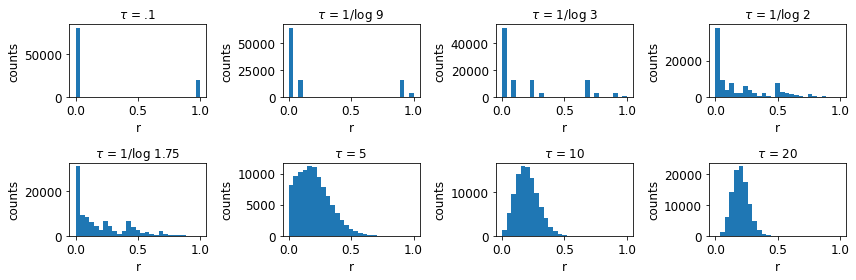

In [8]:
tau = np.array([.1, 1/np.log(9), 1/np.log(3), 1/np.log(2), 1/np.log(1.75), 5, 10, 20])
label = ['.1', '1/log 9', '1/log 3', '1/log 2', '1/log 1.75', '5', '10', '20']
t = int(round(10*tau.max()))
n = 100000

s = np.random.binomial(1, .2, (n, t))

r = s2r(s, tau)

fig, axs = plt.subplots(2, 4, figsize=(12, 4), tight_layout=True)
for label_, r_, ax in zip(label, r.T, axs.flat):
    bins = np.linspace(0, 1, 28)
    bins[0] -= .00001
    bins[-1] += .00001
    ax.hist(r_, bins=bins)
    ax.set_title(fr'$\tau$ = {label_}')
    ax.set_xlabel('r')
    ax.set_ylabel('counts')
    
set_font_size(axs, 12)

In [9]:
from scipy import stats

a = np.linspace(.01, .99, 99)
tau = -1/np.log(a)
t = int(round(10*tau.max()))
n = 500000

s = np.random.binomial(1, .2, (n, t))
r = s2r(s, a=a)

nbin = [3, 9, 27, 81, 243, 729]

h = np.nan * np.zeros((len(nbin), len(a)))
cts_plt = []

for cnbin, nbin_ in enumerate(nbin):
    ct_plt = np.nan * np.zeros((nbin_, len(a)))
    for ctau, r_ in enumerate(r.T):
        bins = np.linspace(0, 1, nbin_+1)
        bins[0] -= .00001
        bins[-1] += .00001
        ct_r = np.histogram(r_, bins=bins)[0]
        h[cnbin, ctau] = stats.entropy(ct_r/np.sum(ct_r), base=2)
        ct_plt[:, ctau] = ct_r/ct_r.max()
        
    cts_plt.append(ct_plt)

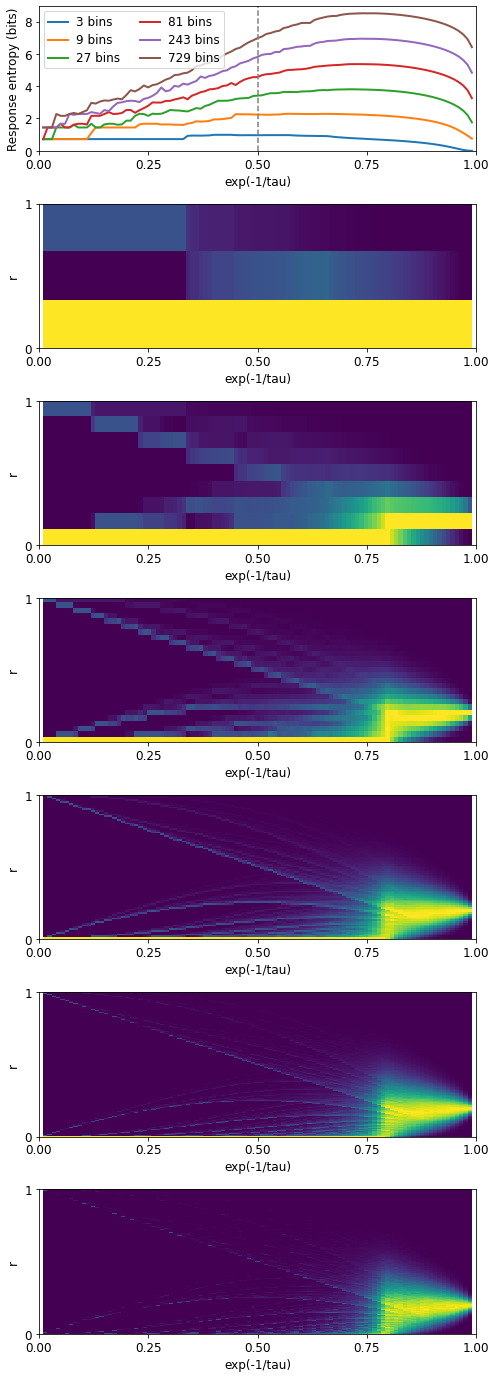

In [10]:
fig, axs = plt.subplots(1+len(nbin), 1, figsize=(7, 2.75*(1+len(nbin))), tight_layout=True)
axs[0].plot(a, h.T, lw=2)
axs[0].axvline(.5, color='gray', ls='--')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(bottom=0)
axs[0].set_xticks(np.linspace(0, 1, 5))
axs[0].set_xlabel('exp(-1/tau)')
axs[0].set_ylabel('Response entropy (bits)')
axs[0].legend([f'{nbin_} bins' for nbin_ in nbin], loc='upper left', ncol=2)

for nbin_, ct_plt, ax in zip(nbin, cts_plt, axs[1:]):
    ax.matshow(ct_plt, origin='lower', interpolation='nearest', extent=[0.01, .99, 0, 1])
    ax.set_aspect('auto')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.xaxis.tick_bottom()
    ax.set_xlabel('exp(-1/tau)')
    ax.set_ylabel('r')
set_font_size(axs, 12)